In [1]:
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from shutil import copyfile

In [11]:
from sklearn.model_selection import train_test_split
os.chdir("C:\\Users\\21269\\Desktop\\data12")
os.getcwd()
list  = os.listdir()
print(list)

['Fresh Apple', 'Fresh Apricot', 'Fresh Avocado', 'Fresh Banana', 'Fresh Cherry', 'Fresh Dates', 'Fresh Grape', 'Fresh Lemon', 'Fresh Mango', 'Fresh Orange', 'Fresh Tomato', 'Fresh Watermelon', 'Not Fruits', 'Rotten Apple', 'Rotten Apricot', 'Rotten Avocado', 'Rotten Banana', 'Rotten Cherry', 'Rotten Dates', 'Rotten Grape', 'Rotten Lemon', 'Rotten Mango', 'Rotten Orange', 'Rotten Tomato', 'Rotten Watermelon']


# Splitting Dataset

In [42]:
data_derectory = ".//dataset100"
os.mkdir(data_derectory)
for folder in list:
    
    path = os.path.join(os.path.join(data_derectory,"train"), folder)
    os.makedirs(path)
    path = os.path.join(os.path.join(data_derectory,"test"), folder)
    os.makedirs(path)
    
    source_folder = os.path.join(".",folder)
    
    destination_folder = os.path.join(os.path.join(data_derectory,"train"), folder)
    
    destination_test = os.path.join(os.path.join(data_derectory,"test"), folder)
    data = os.listdir(folder)
    train , test = train_test_split(data , test_size=0.2 , random_state = 1)
    
    for file in train :
        shutil.copy(os.path.join(source_folder ,file) , os.path.join(destination_folder))
    for file in test :
        shutil.copy(os.path.join(source_folder ,file) , os.path.join(destination_test))

In [13]:
dataset_train_dir = './/dataset100//train'
dataset_test_dir = './/dataset100//test'
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.5, 1.0],
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [14]:
train_generator = train_datagen.flow_from_directory(dataset_train_dir,
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    target_size=(150,150),
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(dataset_test_dir,
                                                         batch_size=32,
                                                         color_mode="rgb",
                                                         target_size=(150,150),
                                                         class_mode='categorical')

Found 34940 images belonging to 25 classes.
Found 8749 images belonging to 25 classes.


In [45]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98):
            print("\nReached 98% accuracy. Stop Training")
            self.model.stop_training = True

callbacks = myCallback()

# Create Model

In [47]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import pandas as pd

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False

x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(25, activation='softmax')(x)

model = Model(pre_trained_model.input, x) 
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in pre_trained_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002D9016B6580>,input_4,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002D9016B66D0>,conv2d_294,False
2,<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x000002D90169ECD0>,batch_normalization_282,False
3,<tensorflow.python.keras.layers.core.Activation object at 0x000002D9215CCD30>,activation_282,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002D9016ADAC0>,conv2d_295,False
...,...,...,...
306,<tensorflow.python.keras.layers.core.Activation object at 0x000002D901A9B1C0>,activation_367,False
307,<tensorflow.python.keras.layers.merge.Concatenate object at 0x000002D901AF8CD0>,mixed9_1,False
308,<tensorflow.python.keras.layers.merge.Concatenate object at 0x000002D901B37C40>,concatenate_7,False
309,<tensorflow.python.keras.layers.core.Activation object at 0x000002D901AFCF10>,activation_375,False


In [48]:
train_len = 0
for foldername in os.listdir(dataset_train_dir):
    train_len = train_len + len(os.listdir(os.path.join(dataset_train_dir,foldername)))
    
val_len = 0
for foldername in os.listdir(dataset_test_dir):
    val_len = val_len + len(os.listdir(os.path.join(dataset_test_dir,foldername)))
    
print(train_len)
print(val_len)

34940
8749


# Model Architecture

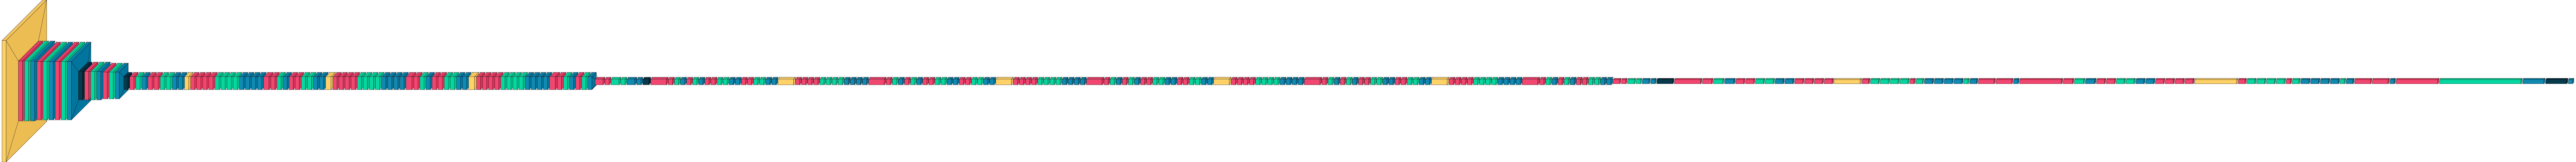

In [15]:
import visualkeras
visualkeras.layered_view(model_predict)

# Model Training

In [49]:
history = model.fit(
    train_generator,
    steps_per_epoch=(train_len/32),
    epochs=32,
    verbose=1,
    callbacks=[callbacks],
    validation_data=validation_generator,
    validation_steps=(val_len/32)
)

Epoch 1/32
1091/1091 [==============================] - 1869s 2s/step - loss: 4.4322 - accuracy: 0.5698 - val_loss: 0.6688 - val_accuracy: 0.7858
Epoch 2/32
1091/1091 [==============================] - 1588s 1s/step - loss: 0.8540 - accuracy: 0.7301 - val_loss: 0.5812 - val_accuracy: 0.8108
Epoch 3/32
1091/1091 [==============================] - 1590s 1s/step - loss: 0.7429 - accuracy: 0.7671 - val_loss: 0.6206 - val_accuracy: 0.7985
Epoch 4/32
1091/1091 [==============================] - 1603s 1s/step - loss: 0.7203 - accuracy: 0.7777 - val_loss: 0.5748 - val_accuracy: 0.8270
Epoch 5/32
1091/1091 [==============================] - 1652s 2s/step - loss: 0.6684 - accuracy: 0.7897 - val_loss: 0.5183 - val_accuracy: 0.8345
Epoch 6/32
1091/1091 [==============================] - 1627s 1s/step - loss: 0.6894 - accuracy: 0.7841 - val_loss: 0.4983 - val_accuracy: 0.8404
Epoch 7/32
1091/1091 [==============================] - 1596s 1s/step - loss: 0.6551 - accuracy: 0.7943 - val_loss: 0.4814 -

# Plotting Learning Curves 

<Figure size 432x288 with 0 Axes>

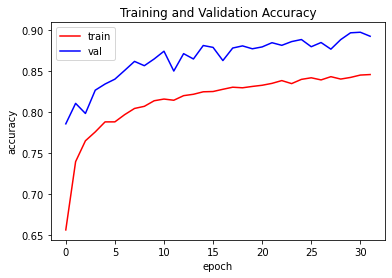

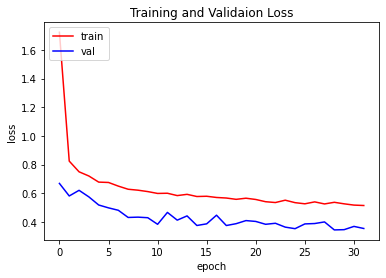

<Figure size 432x288 with 0 Axes>

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
len_training = range(train_len)

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.figure()

<Figure size 432x288 with 0 Axes>

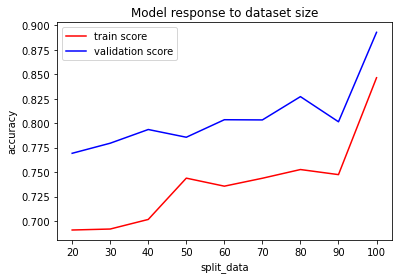

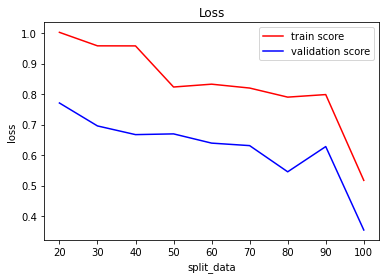

<Figure size 432x288 with 0 Axes>

In [3]:
acc = [0.6909,0.6919,0.7017,0.7439,0.7357,0.7438,0.7527,0.7475,0.8465]
loss = [1.0030,0.9587,0.9585,0.8236,0.8329,0.8202,0.7904,0.7988,0.5173]
val_acc = [0.7693,0.7796,0.7936,0.7857,0.8036,0.8034,0.8272,0.8015,0.8929]
val_loss = [0.7712,0.6959,0.6674,0.6698,0.6395,0.6313,0.5454,0.6282,0.3544]

data = [20,30,40,50,60,70,80,90,100]

plt.plot(data, acc, 'r')
plt.plot(data, val_acc, 'b')
plt.title('Model response to dataset size')
plt.ylabel('accuracy')
plt.xlabel('split_data')
plt.legend(['train score', 'validation score'], loc='upper left')
plt.figure()

plt.plot(data, loss, 'r')
plt.plot(data, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('split_data')
plt.legend(['train score', 'validation score'], loc='upper right')
plt.title('Loss')
plt.figure()

In [52]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(dataset_test_dir,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  shuffle = False,
                                                  class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)

Found 8749 images belonging to 25 classes.
8749/8749 [==============================] - 515s 59ms/step - loss: 0.2807 - accuracy: 0.9136
accuracy test:  0.913590133190155


In [18]:
os.chdir("C:\\Users\\21269\\Desktop\\pfe\\interface\\Models")
os.getcwd()

'C:\\Users\\21269\\Desktop\\pfe\\interface\\Models'

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(dataset_test_dir,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  shuffle = False,
                                                  class_mode='categorical')

Found 8749 images belonging to 25 classes.


In [ ]:
model.save("model_final100.h5")

In [19]:
import pathlib

model_predict = tf.keras.models.load_model('model_final100.h5')

In [20]:
predictions = model_predict.predict_generator(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

list_l = []
for i in true_classes :
    list_l.append(i)
    
class_labels = list_l

C:\Users\21269\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


# Confusion Matrix

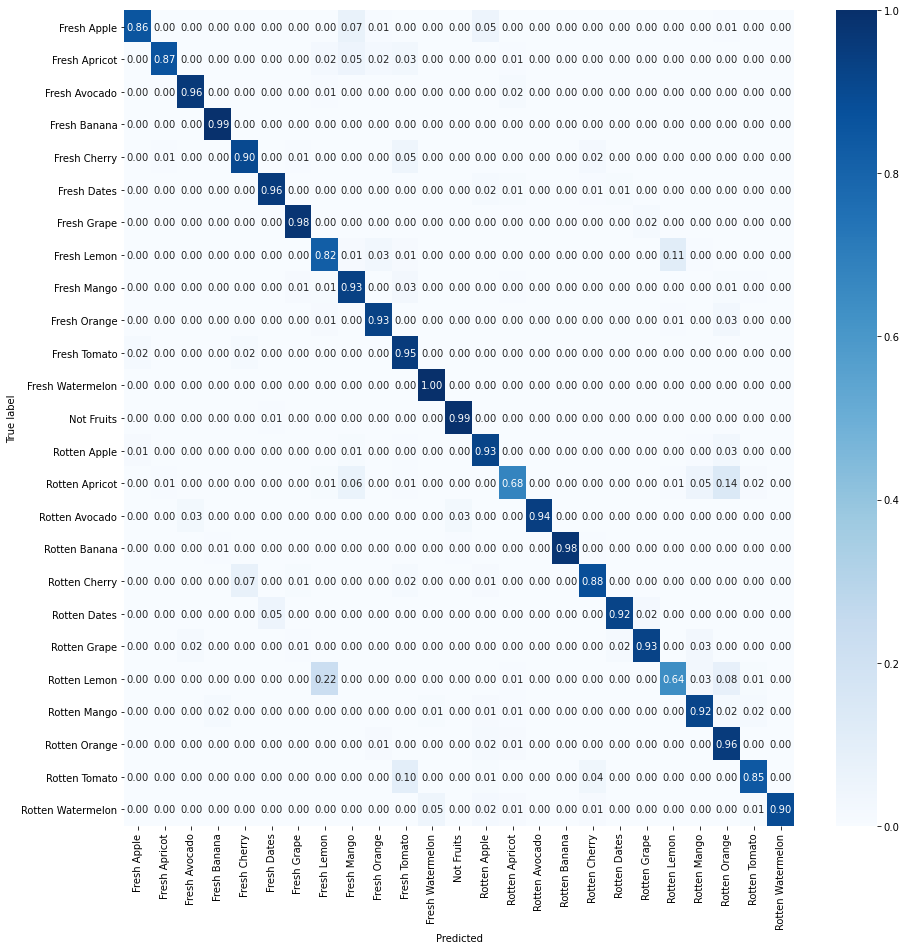

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
list_name = os.listdir("C:\\Users\\21269\\Desktop\\dataset100\\train")
cm = confusion_matrix(true_classes,predicted_classes)
# Normalise
cmn = cm.astype('float') /cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=list_name, yticklabels=list_name,cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show(block=False)

# Performance Metrics

In [63]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(true_classes,predicted_classes)

0.9135901245856669

In [27]:
# Recall
from sklearn.metrics import recall_score
recall_score(true_classes,predicted_classes, average=None)

array([0.85835694, 0.86577181, 0.96190476, 0.99494949, 0.90328152,
       0.95652174, 0.97689769, 0.82133995, 0.93469388, 0.93197279,
       0.95414201, 1.        , 0.99324324, 0.92537313, 0.67938931,
       0.94375   , 0.97977528, 0.884375  , 0.92409241, 0.92834891,
       0.63897764, 0.91798107, 0.95611285, 0.84539474, 0.89787234])

In [65]:
# Precision
from sklearn.metrics import precision_score
precision_score(true_classes,predicted_classes, average=None)

array([0.93518519, 0.94852941, 0.95283019, 0.98336106, 0.93226381,
       0.93902439, 0.94871795, 0.79186603, 0.78694158, 0.91946309,
       0.88477366, 0.95114007, 0.96710526, 0.90416667, 0.87684729,
       0.9869281 , 0.99316629, 0.88714734, 0.96885813, 0.96129032,
       0.8       , 0.88181818, 0.75308642, 0.92114695, 0.99528302])

In [66]:
from sklearn.metrics import f1_score
f1_score(true_classes,predicted_classes, average=None)

array([0.89512555, 0.90526316, 0.95734597, 0.98912134, 0.91754386,
       0.94769231, 0.96260163, 0.80633374, 0.85447761, 0.92567568,
       0.91814947, 0.97495826, 0.98      , 0.914647  , 0.7655914 ,
       0.96485623, 0.98642534, 0.885759  , 0.94594595, 0.94453249,
       0.71047957, 0.89953632, 0.84254144, 0.88164666, 0.94407159])

# Make Prediction

In [29]:
def traiter(fn):
    image_name = []
    image_conf = []
    predict_result = []
    img = image.load_img(fn, color_mode="rgb", target_size=(150, 150), interpolation="nearest")
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    images = np.vstack([img])
    classes = model_predict.predict(images, batch_size=10)
    max = np.amax(classes[0])   
    if np.where(classes[0] == max)[0] == 0:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Apple')
    elif np.where(classes[0] == max)[0] == 1:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Apricot')
    elif np.where(classes[0] == max)[0] == 2:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Avocado')
    elif np.where(classes[0] == max)[0] == 3:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Banana')
    elif np.where(classes[0] == max)[0] == 4:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Cherry')
    elif np.where(classes[0] == max)[0] == 5:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Dates')
    elif np.where(classes[0] == max)[0] == 6:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Grape')
    elif np.where(classes[0] == max)[0] == 7:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Lemon')
    elif np.where(classes[0] == max)[0] == 8:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Mango')
    elif np.where(classes[0] == max)[0] == 9:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Orange')
    elif np.where(classes[0] == max)[0] == 10:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Tomato')
    elif np.where(classes[0] == max)[0] == 11:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Fresh Watermelon')
    elif np.where(classes[0] == max)[0] == 12:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Not Fruits')
    elif np.where(classes[0] == max)[0] == 13:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Apple')
    elif np.where(classes[0] == max)[0] == 14:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Apricot')
    elif np.where(classes[0] == max)[0] == 15:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Avocado')
    elif np.where(classes[0] == max)[0] == 16:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Banana')
    elif np.where(classes[0] == max)[0] == 17:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Cherry')
    elif np.where(classes[0] == max)[0] == 18:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Dates')
    elif np.where(classes[0] == max)[0] == 19:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Grape')
    elif np.where(classes[0] == max)[0] == 20:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Lemon')
    elif np.where(classes[0] == max)[0] == 21:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Mango')
    elif np.where(classes[0] == max)[0] == 22:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Orange')
    elif np.where(classes[0] == max)[0] == 23:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Tomato')
    elif np.where(classes[0] == max)[0] == 24:
        image_name.append(fn)
        image_conf.append(max)
        predict_result.append('Rotten Watermelon')
    plt.figure(figsize=(15, 15))
        
    for n in range(len(image_name)):
        plt.subplot((len(image_name)/4)+1,4,n+1)
        plt.subplots_adjust(hspace = 0.3)
        plt.imshow(image.load_img(image_name[n], color_mode="rgb", target_size=(250, 250), interpolation="nearest"))
        title = f"PREDIRE : {predict_result[n]} ({round(float(image_conf[n])*100, 2)}%)"
        if predict_result[n]=='Rotten Apple' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Banana' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Apicot' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Avocado' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Cherry' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Dates' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Grape' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Lemon' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Mango' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Orange' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Tomato' :
            plt.title(title, color='red')
        elif predict_result[n]=='Rotten Watermelon' :
            plt.title(title, color='red')
        else:
            plt.title(title, color='green') 
            plt.axis('off')
    return image_name,image_conf

<ipython-input-29-1ff86d87883b>:115: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot((len(image_name)/4)+1,4,n+1)


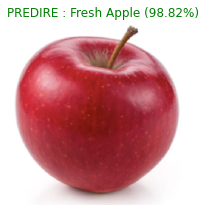

In [31]:
image_name,image_conf = traiter("C:/Users/21269/Desktop/Test/ap8.png")